In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import rpy2
from scipy import stats
import seaborn
import sys

print(f'Package versions:\nPython {sys.version}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'rpy2 {rpy2.__version__}, scipy {sys.modules["scipy"].__version__}, seaborn {seaborn.__version__}')

%load_ext rpy2.ipython

Package versions:
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0], matplotlib 3.8.0, numpy 1.24.4, pandas 2.1.1, rpy2 3.5.11, scipy 1.11.3, seaborn 0.13.0


In [2]:
valid_cells = pandas.read_csv('./heteroplasmy_dataframe.csv')
print(valid_cells.shape)
valid_cells.head()

(15078, 13)


,cell_id,condition,umi_count,LHON,LHON/SILENT,SILENT,WT,umi_count_for_filtering,umi_count_rank,LHON_het,SILENT_het,SILENT_ONLY_het,total_het
0,A1-CCGTGAGA-TGCCAGCC,d5_silent_r1,61,0,0,52,9,61,3649,0.000000,0.852459,0.852459,0.852459
1,A1-ACGCTCGA-TGTCTCAT,d0_silent_r3,65,0,0,61,4,65,3091,0.000000,0.938462,0.938462,0.938462
2,A1-AGTACAAG-GCATGCCG,d0_lhon_r3,44,0,32,12,0,44,7158,0.727273,1.000000,0.272727,1.000000
3,A1-ACTCTTAG-GTTGCTGT,d10_silent_r3,64,0,0,47,17,64,3223,0.000000,0.734375,0.734375,0.734375
4,A1-CGAACTTA-TGCCAGCC,d5_silent_r1,93,0,0,91,2,93,1068,0.000000,0.978495,0.978495,0.978495


In [3]:
valid_cells['condition_no_rep'] = ['_'.join(elt.split('_')[:2]) for elt in valid_cells['condition'].values]

### Load the Kimura distribution testing libraries

In [4]:
%%R

library(kimura)
library(heteroplasmy)

sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /broad/moothalab/sandbox/tdurham/anaconda/envs/kimura/lib/libopenblasp-r0.3.24.so

locale:
[1] C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] heteroplasmy_0.0.2.1 kimura_0.0.0.9001   

loaded via a namespace (and not attached):
[1] compiler_4.2.3


In [5]:
%%R

lsf.str('package:kimura')

dkimura : function (x, p, b)  
estimate_parameters : function (h)  
nvar : function (H, percent = TRUE)  
pkimura : function (x, p, b)  
rkimura : function (n, p, b)  
shift : function (H, H0, percent = TRUE, tol = 1e-04)  
test_kimura : function (h, num_MC = 1000, round = TRUE)  


In [6]:
%%R

lsf.str('package:heteroplasmy')

analyticVar : function (data, normal = FALSE, method = "hstatistic")  
analyticVarKimura : function (data, p, b)  
bootstrapVar : function (data, nrep = 1000, biased = FALSE)  
estimate_parameters_ks : function (h)  
estimate_parameters_ml : function (h)  
heteroplasmyShift : function (h, h0)  
hstats : function (h, h0 = F, usepopn = F)  
invtransfun : function (x)  
jackVar : function (data)  
joint_neg_log_lik : function (theta, hlist, use.h0s = F, h0s = -1)  
kimura_lrt : function (h1, h2, use.h0s = F, h1.h0set = 0, h2.h0set = 0)  
kimura_neg_loglik : function (theta, h, h0 = F)  
ks_dist : function (theta, ecdf)  
maxlik : function (h, conf.level = 0.95, h0 = F)  
maxlikboot : function (h, nboot = 1000, conf.level = 0.95, h0 = F)  
plotStdErrVar : function (data, functions = c("normalApr", "analytic", "bootstrap", "jackknife"), 
    ...)  
readHeteroplasmyData : function (nameD = "HB")  
test_kimura_par : function (h, p, b, num_MC = 1000, round = FALSE)  
transfun : function (x)  


### Customize some of their functions so that I can hard-code h0 to be the d0 heteroplasmy

In [7]:
%%R

kimura_neg_loglik2 = function(theta, h, h0=F) {
  # get kimura parameters from argument
  b = transfun(theta)
  # compute the negative log likelihood using the dkimura function
  return(-sum(log(kimura::dkimura(h, h0, b))))
}

estimate_parameters_ml2 <- function(h, h0) {
  # find best transformed parameter value for b
  best = optim(0.5, kimura_neg_loglik2, h=h, h0=h0, hessian=F)

  #make sure the estimated b is in the range 0 to 1
  best$b.hat = transfun(best$par[1])
  #simply record the estimated h0 as the provided value
  best$h0.hat = h0

  #return the parameter values after ML fitting
  return(c(best$h0.hat, best$b.hat))
}

In [8]:
%%R

ks_dist2 = function(theta, h0, ecdf) {
  b = transfun(theta)
  cdf_kimura <- kimura::.pkimura_full(h0, b)
  return(max(abs(ecdf - cdf_kimura)))
}

estimate_parameters_ks2 = function(h, h0) {
  ecdf_h <- (stats::ecdf(h))(seq(0, 1, 1e-04))

  mom.best = kimura::estimate_parameters(h)
  mom.b = mom.best[2]
  ml.best = estimate_parameters_ml2(h, h0)
  ml.b = ml.best[2]

  mom.best = stats::optim(invtransfun(mom.b), ks_dist2, h0 = h0, ecdf = ecdf_h)
  ml.best = stats::optim(invtransfun(ml.b), ks_dist2, h0 = h0, ecdf = ecdf_h)

  if(ml.best$value < mom.best$value) {
    b.hat = transfun(ml.best$par[1])
    h0.hat = h0
  } else {
    b.hat = transfun(mom.best$par[1])
    h0.hat = h0
  }

  return(c(h0.hat, b.hat))
}

### Extract just the day 0 and day 5 data and remove homoplasmic wild type cells

In [9]:
h0_silent_data = valid_cells.loc[(valid_cells['condition_no_rep'] == 'd0_silent')
                                 & (valid_cells['SILENT_ONLY_het'] > 0), 'SILENT_ONLY_het']
h0_silent = h0_silent_data.mean()
print(f'Day 0 SILENT mean heteroplasmy: {h0_silent:0.2f} +- {stats.sem(h0_silent_data):0.3f}')

h0_lhon_data = valid_cells.loc[(valid_cells['condition_no_rep'] == 'd0_lhon')
                               & (valid_cells['LHON_het'] > 0), 'LHON_het']
h0_lhon = h0_lhon_data.mean()
print(f'Day 0 LHON mean heteroplasmy: {h0_lhon:0.2f} +- {stats.sem(h0_lhon_data):0.3f}')

Day 0 SILENT mean heteroplasmy: 0.75 +- 0.004
Day 0 LHON mean heteroplasmy: 0.72 +- 0.005


In [10]:
d5_silent_hets = valid_cells.loc[(valid_cells['condition_no_rep'] == 'd5_silent')
                                 & (valid_cells['SILENT_ONLY_het'] > 0), 'SILENT_ONLY_het'].values
d5_lhon_hets = valid_cells.loc[(valid_cells['condition_no_rep'] == 'd5_lhon')
                               & (valid_cells['LHON_het'] > 0), 'LHON_het'].values

### Find the ML estimates of either h0 and b together, or just b, and use the MonteCarlo KS-based test to check the fit.

### SILENT-edited cells

In [11]:
%%R -i h0_silent -i d5_silent_hets

#fit both p and b
ml_opt_h0_fit = estimate_parameters_ml(d5_silent_hets)

#fit just b
ml_opt_h0_fix = estimate_parameters_ml2(d5_silent_hets, h0_silent)

#test the fits
print(h0_silent)

[1] 0.7476405


In [12]:
%%R

print(test_kimura_par(d5_silent_hets, ml_opt_h0_fit[1], ml_opt_h0_fit[2], num_MC=100))
print(test_kimura_par(d5_silent_hets, h0_silent, ml_opt_h0_fix[2], num_MC=100))


	Monte Carlo Kolmogorov-Smirnov

data:  d5_silent_hets and Kimura(0.752, 0.8725)
D = 0.040076, p = 0.752048, b = 0.872498, p-value = 0.0198
alternative hypothesis: one-sided


	Monte Carlo Kolmogorov-Smirnov

data:  d5_silent_hets and Kimura(0.7476, 0.8711)
D = 0.051217, p = 0.747640, b = 0.871052, p-value = 0.009901
alternative hypothesis: one-sided



In [13]:
%%R

#print the parameter values for the two models
print(ml_opt_h0_fit)
print(ml_opt_h0_fix)

[1] 0.7520481 0.8724978
[1] 0.7476405 0.8710517


In [14]:
%%R -o xvals -o silent_full_dkimura_hfit -o silent_full_dkimura_hfix

xvals = seq(0,1,0.02)

#compute the log likelihood and the Kimura pdf based on fitting both p and b
h0_fit = 0.7520481
b_hfit=0.8724978
nontrunc_llike_hfit = sum(log(kimura::dkimura(d5_silent_hets, h0_fit, b_hfit)))
silent_full_dkimura_hfit = kimura::dkimura(xvals, h0_fit, b_hfit)

#compute the log likelihood and the Kimura pdf based on fitting just b
h0_fix = 0.7476405
b_hfix=0.8710517
nontrunc_llike_hfix = sum(log(kimura::dkimura(d5_silent_hets, h0_fix, b_hfix)))
silent_full_dkimura_hfix = kimura::dkimura(xvals, h0_fix, b_hfix)

print(nontrunc_llike_hfit)
print(nontrunc_llike_hfix)

[1] 1289.162
[1] 1289.892


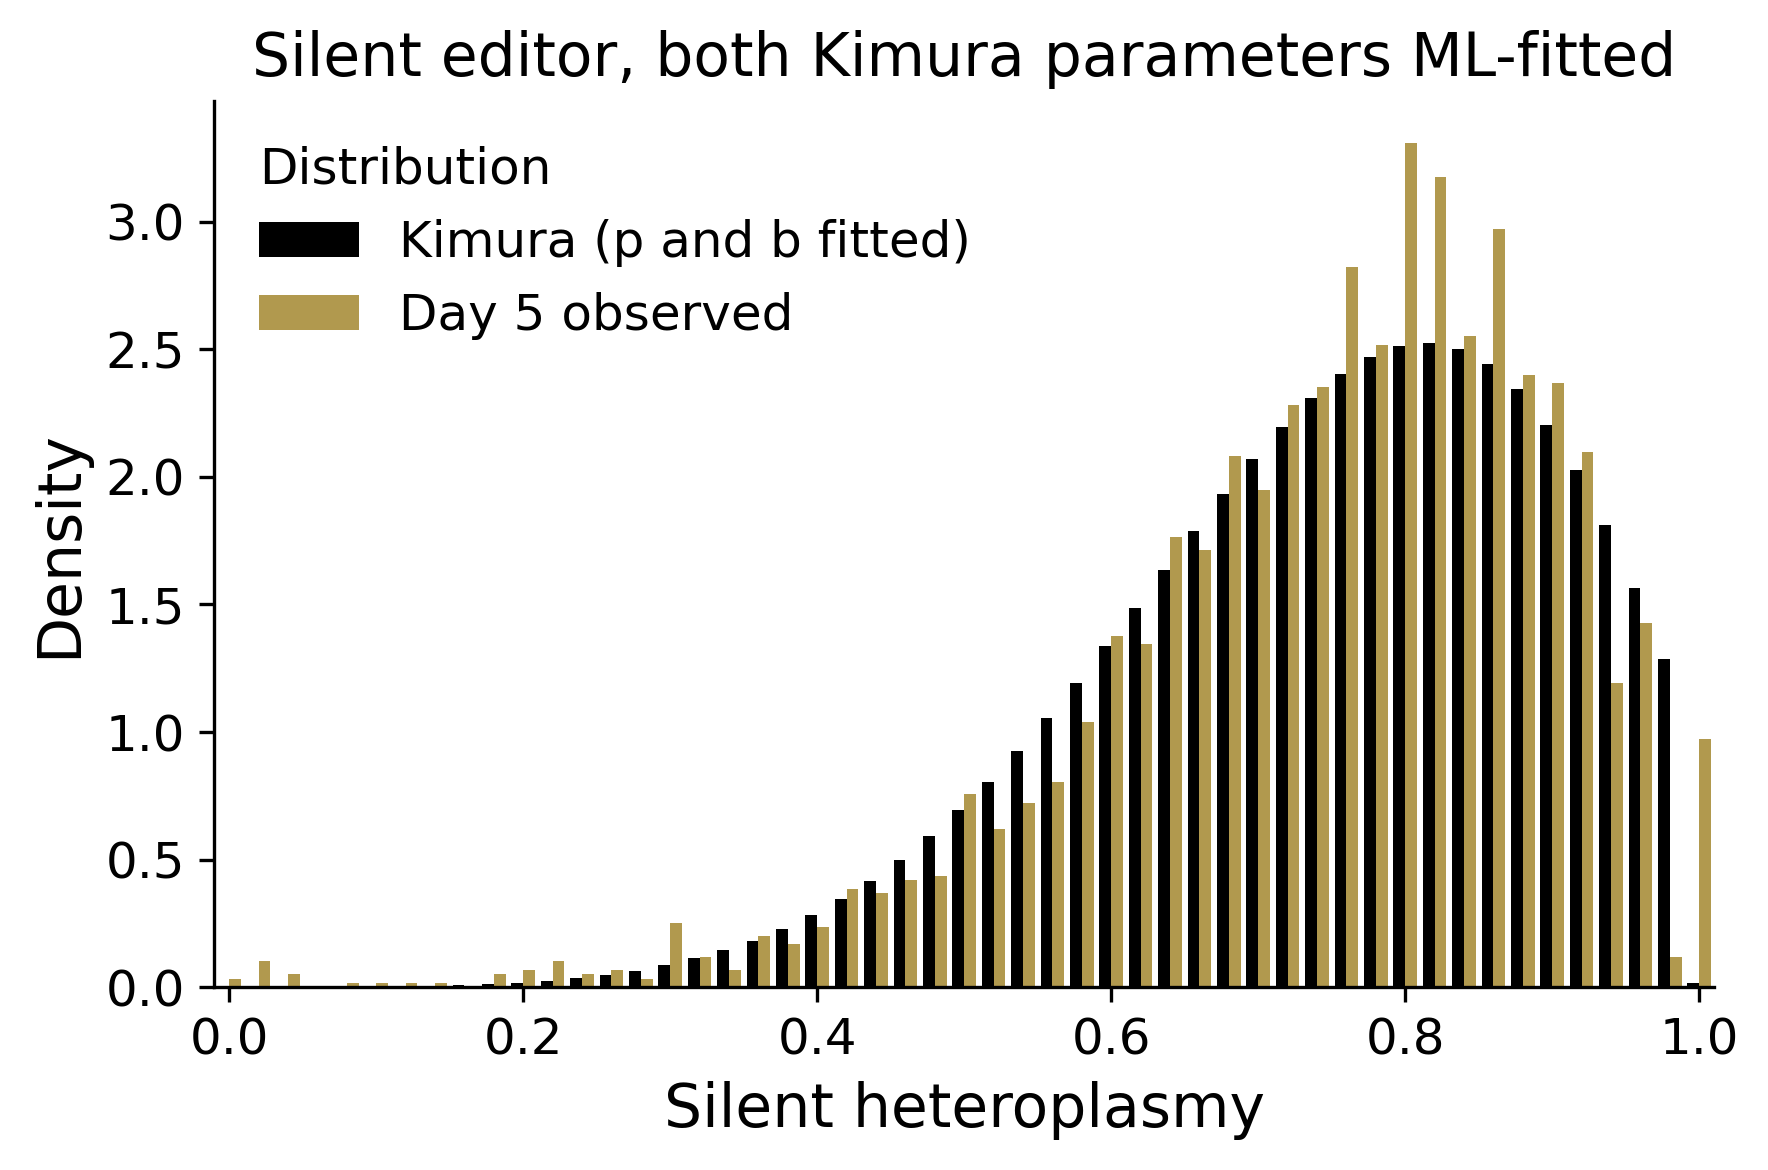

In [15]:
#plot the day 5 data and Kimura distributions after fitting both p and b
exp_hist = numpy.histogram(d5_silent_hets, numpy.append(xvals, 1.02), density=True)
to_plot = pandas.DataFrame({'xvals':numpy.hstack([xvals, xvals]),
                            'dist_type':['Kimura (p and b fitted)']*xvals.shape[0] + ['Day 5 observed']*xvals.shape[0],
                            'pdf':numpy.hstack([silent_full_dkimura_hfit, exp_hist[0]])})

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
palette = [(0,0,0,1), (193/255,162/255,61/255,1)]
hue_order = ['Kimura (p and b fitted)', 'Day 5 observed']
seaborn.barplot(data=to_plot, x='xvals', y='pdf', hue='dist_type', hue_order=hue_order, palette=palette, ax=axes)
xticks = numpy.arange(0,xvals.shape[0],10)
axes.set_xticks(xticks)
axes.set_ylabel('Density', fontsize='x-large')
axes.set_xlabel('Silent heteroplasmy', fontsize='x-large')
axes.tick_params(axis='both', labelsize='large')

axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Silent editor, both Kimura parameters ML-fitted', fontsize='x-large')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='best', frameon=False, title='Distribution', alignment='left', title_fontsize='large', fontsize='large')
fig.tight_layout()

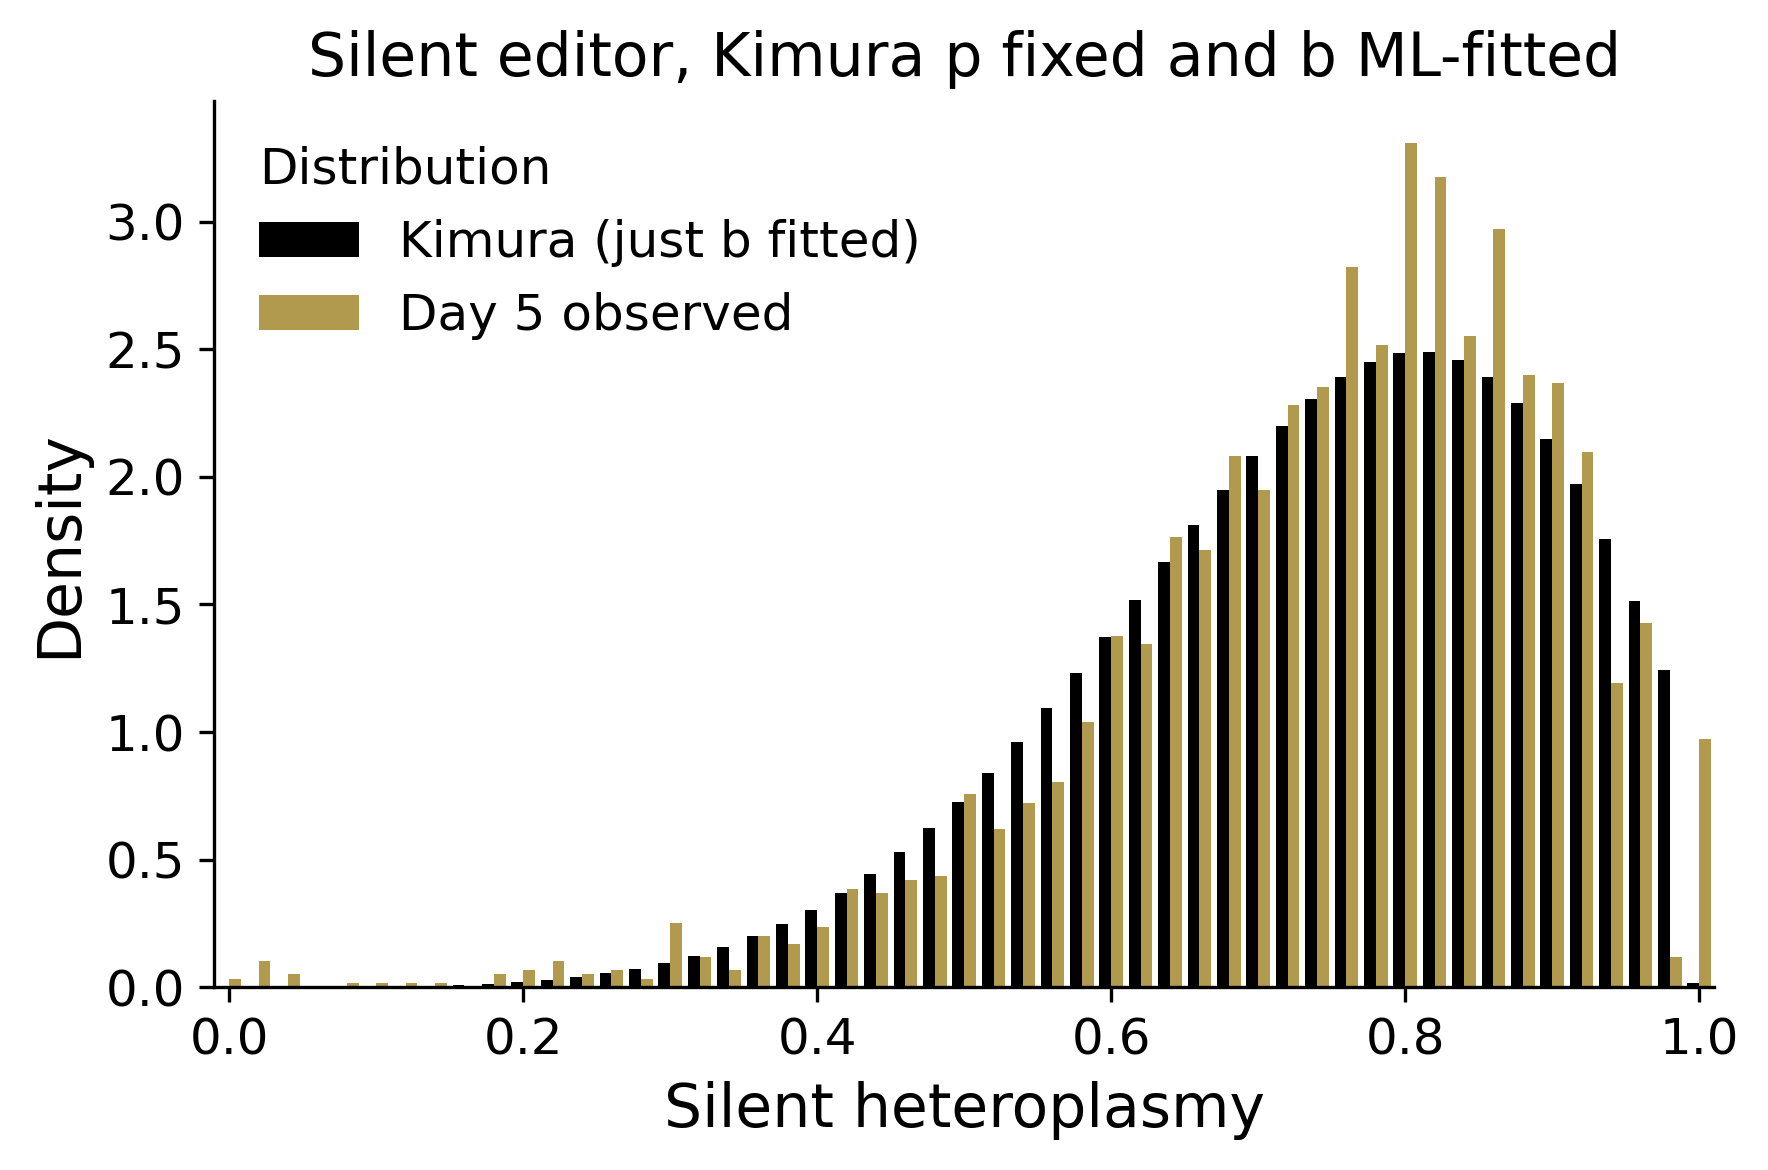

In [16]:
#plot the day 5 data and Kimura distributions after fitting just b
exp_hist = numpy.histogram(d5_silent_hets, numpy.append(xvals, 1.02), density=True)
to_plot = pandas.DataFrame({'xvals':numpy.hstack([xvals, xvals]),
                            'dist_type':['Kimura (just b fitted)']*xvals.shape[0] + ['Day 5 observed']*xvals.shape[0],
                            'pdf':numpy.hstack([silent_full_dkimura_hfix, exp_hist[0]])})

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
palette = [(0,0,0,1), (193/255,162/255,61/255,1)]
hue_order = ['Kimura (just b fitted)', 'Day 5 observed']
seaborn.barplot(data=to_plot, x='xvals', y='pdf', hue='dist_type', hue_order=hue_order, palette=palette, ax=axes)
xticks = numpy.arange(0,xvals.shape[0],10)
axes.set_xticks(xticks)
axes.tick_params(axis='both', labelsize='large')
axes.set_ylabel('Density', fontsize='x-large')
axes.set_xlabel('Silent heteroplasmy', fontsize='x-large')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Silent editor, Kimura p fixed and b ML-fitted', fontsize='x-large')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='best', frameon=False, title='Distribution', alignment='left', title_fontsize='large', fontsize='large')
fig.tight_layout()

In [17]:
%%R -i h0_silent -i d5_silent_hets

#fit both p and b using KS
ks_opt_h0_fit = estimate_parameters_ks(d5_silent_hets)

In [18]:
%%R

#fit just b using KS
ks_opt_h0_fix = estimate_parameters_ks2(d5_silent_hets, h0_silent)

In [19]:
%%R

#test the fits
print(test_kimura_par(d5_silent_hets, ks_opt_h0_fit[1], ks_opt_h0_fit[2], num_MC=100))
print(test_kimura_par(d5_silent_hets, h0_silent, ks_opt_h0_fix[2], num_MC=100))


	Monte Carlo Kolmogorov-Smirnov

data:  d5_silent_hets and Kimura(0.7597, 0.8869)
D = 0.021358, p = 0.759726, b = 0.886857, p-value = 0.2772
alternative hypothesis: one-sided


	Monte Carlo Kolmogorov-Smirnov

data:  d5_silent_hets and Kimura(0.7476, 0.8658)
D = 0.050059, p = 0.747640, b = 0.865821, p-value = 0.009901
alternative hypothesis: one-sided



In [20]:
%%R

#print the parameter values for the two models
print(ks_opt_h0_fit)
print(ks_opt_h0_fix)

[1] 0.7597263 0.8868568
[1] 0.7476405 0.8658210


### LHON-edited cells

In [21]:
%%R -i h0_lhon -i d5_lhon_hets

#fit both p and b
ml_opt_h0_fit = estimate_parameters_ml(d5_lhon_hets)

#fit just b
ml_opt_h0_fix = estimate_parameters_ml2(d5_lhon_hets, h0_lhon)

#test the fits
print(h0_lhon)

[1] 0.7229424


In [22]:
%%R

print(test_kimura_par(d5_lhon_hets, ml_opt_h0_fit[1], ml_opt_h0_fit[2], num_MC=100))
print(test_kimura_par(d5_lhon_hets, h0_lhon, ml_opt_h0_fix[2], num_MC=100))


	Monte Carlo Kolmogorov-Smirnov

data:  d5_lhon_hets and Kimura(0.6172, 0.8456)
D = 0.072661, p = 0.617193, b = 0.845578, p-value = 0.009901
alternative hypothesis: one-sided


	Monte Carlo Kolmogorov-Smirnov

data:  d5_lhon_hets and Kimura(0.7229, 0.8218)
D = 0.25739, p = 0.72294, b = 0.82179, p-value = 0.009901
alternative hypothesis: one-sided



In [23]:
%%R

#print the parameter values for the two models
print(ml_opt_h0_fit)
print(ml_opt_h0_fix)

[1] 0.6171928 0.8455777
[1] 0.7229424 0.8217857


In [24]:
%%R -o xvals -o lhon_full_dkimura_hfit -o lhon_full_dkimura_hfix

xvals = seq(0,1,0.02)

#compute the log likelihood and the Kimura pdf based on fitting both p and b
h0_fit = 0.6171928
b_hfit = 0.8455777
nontrunc_llike_hfit = sum(log(kimura::dkimura(d5_lhon_hets, h0_fit, b_hfit)))
lhon_full_dkimura_hfit = kimura::dkimura(xvals, h0_fit, b_hfit)

#compute the log likelihood and the Kimura pdf based on fitting just b
h0_fix = 0.7229424
b_hfix = 0.8217857
nontrunc_llike_hfix = sum(log(kimura::dkimura(d5_lhon_hets, h0_fix, b_hfix)))
lhon_full_dkimura_hfix = kimura::dkimura(xvals, h0_fix, b_hfix)

print(nontrunc_llike_hfit)
print(nontrunc_llike_hfix)

[1] 219.5913
[1] 77.12112


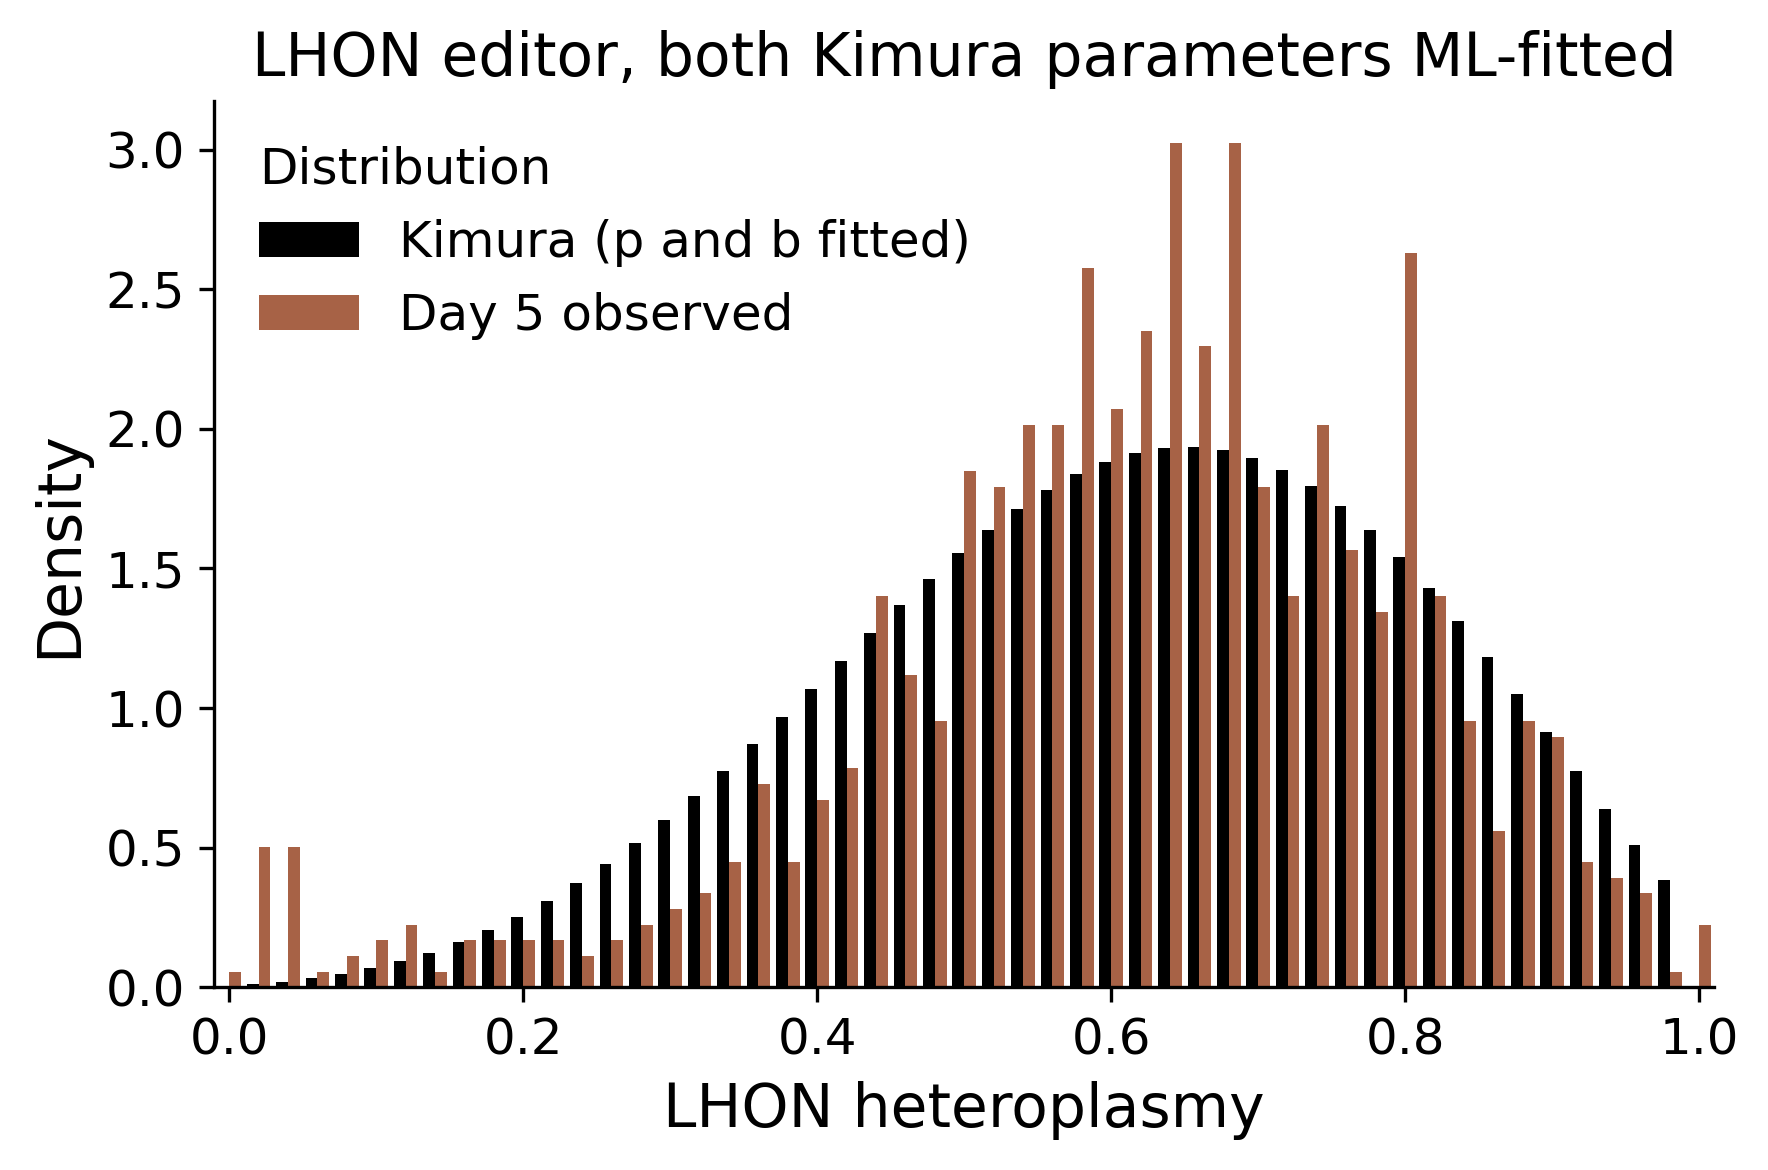

In [25]:
#plot the day 5 data and Kimura distributions after fitting both p and b
exp_hist = numpy.histogram(d5_lhon_hets, numpy.append(xvals, 1.02), density=True)
to_plot = pandas.DataFrame({'xvals':numpy.hstack([xvals, xvals]),
                            'dist_type':['Kimura (p and b fitted)']*xvals.shape[0] + ['Day 5 observed']*xvals.shape[0],
                            'pdf':numpy.hstack([lhon_full_dkimura_hfit, exp_hist[0]])})

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
palette = [(0,0,0,1), (183/255,91/255,54/255,1)]
hue_order = ['Kimura (p and b fitted)', 'Day 5 observed']
seaborn.barplot(data=to_plot, x='xvals', y='pdf', hue='dist_type', hue_order=hue_order, palette=palette, ax=axes)
xticks = numpy.arange(0,xvals.shape[0],10)
axes.set_xticks(xticks)
axes.tick_params(axis='both', labelsize='large')
axes.set_ylabel('Density', fontsize='x-large')
axes.set_xlabel('LHON heteroplasmy', fontsize='x-large')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('LHON editor, both Kimura parameters ML-fitted', fontsize='x-large')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='best', frameon=False, title='Distribution', alignment='left', title_fontsize='large', fontsize='large')
fig.tight_layout()

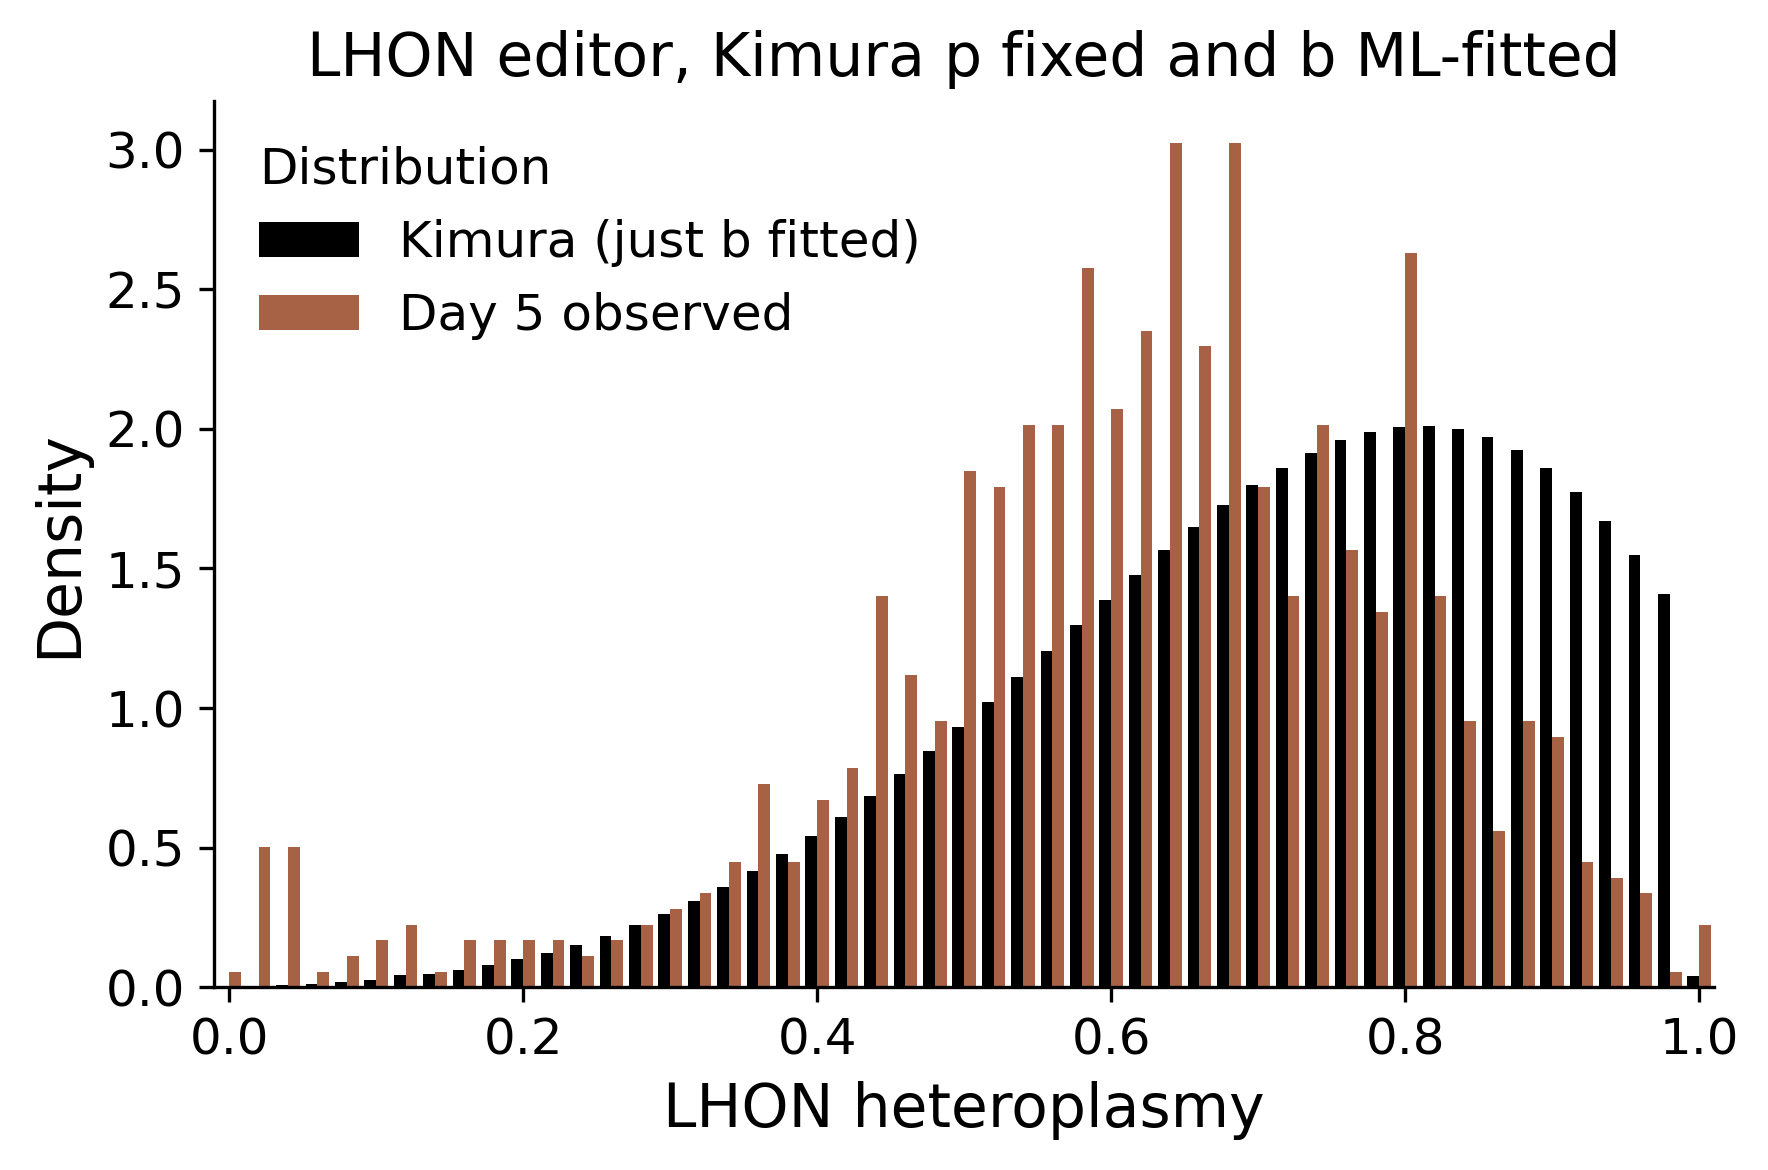

In [26]:
#plot the day 5 data and Kimura distributions after fitting just b
exp_hist = numpy.histogram(d5_lhon_hets, numpy.append(xvals, 1.02), density=True)
to_plot = pandas.DataFrame({'xvals':numpy.hstack([xvals, xvals]),
                            'dist_type':['Kimura (just b fitted)']*xvals.shape[0] + ['Day 5 observed']*xvals.shape[0],
                            'pdf':numpy.hstack([lhon_full_dkimura_hfix, exp_hist[0]])})

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
palette = [(0,0,0,1), (183/255,91/255,54/255,1)]
hue_order = ['Kimura (just b fitted)', 'Day 5 observed']
seaborn.barplot(data=to_plot, x='xvals', y='pdf', hue='dist_type', hue_order=hue_order, palette=palette, ax=axes)
xticks = numpy.arange(0,xvals.shape[0],10)
axes.set_xticks(xticks)
axes.tick_params(axis='both', labelsize='large')
axes.set_ylabel('Density', fontsize='x-large')
axes.set_xlabel('LHON heteroplasmy', fontsize='x-large')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('LHON editor, Kimura p fixed and b ML-fitted', fontsize='x-large')
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, loc='best', frameon=False, title='Distribution', alignment='left', title_fontsize='large', fontsize='large')
fig.tight_layout()

In [27]:
%%R -i h0_lhon -i d5_lhon_hets

#fit both p and b using KS
ks_opt_h0_fit = estimate_parameters_ks(d5_lhon_hets)

#fit just b using KS
ks_opt_h0_fix = estimate_parameters_ks2(d5_lhon_hets, h0_lhon)

#test the fits
print(h0_lhon)

[1] 0.7229424


In [28]:
%%R

print(test_kimura_par(d5_lhon_hets, ks_opt_h0_fit[1], ks_opt_h0_fit[2], num_MC=100))
print(test_kimura_par(d5_lhon_hets, h0_lhon, ks_opt_h0_fix[2], num_MC=100))


	Monte Carlo Kolmogorov-Smirnov

data:  d5_lhon_hets and Kimura(0.6289, 0.8711)
D = 0.033397, p = 0.628903, b = 0.871077, p-value = 0.2178
alternative hypothesis: one-sided


	Monte Carlo Kolmogorov-Smirnov

data:  d5_lhon_hets and Kimura(0.7229, 0.8819)
D = 0.25391, p = 0.72294, b.b = 0.88186, p-value = 0.009901
alternative hypothesis: one-sided



In [29]:
%%R

#print the parameter values for the two models
print(ks_opt_h0_fit)
print(ks_opt_h0_fix)

[1] 0.6289033 0.8710768
                  b 
0.7229424 0.8818599 
